# VIIRS

This notebook downloads and processes the VIIRS instrument data to get an estimate of the average global cloud cover on the Earth during the dates observed in TESS Sectors 1 and 2.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import starry
from scipy import ndimage

## Download the VIIRS data for July-September 2018

In [3]:
# Attempt to load the images
files = glob.glob("../data/*.jpeg")
if len(files) != 28:
    # Run the wget script to download them
    !../data/viirs.sh
    !mv *.jpeg ../data/
images = []
for file in files:
    img = np.asarray(Image.open(file)) / 255.
    csum = np.sum(img, axis=-1)
    img[csum == 0] = [np.nan, np.nan, np.nan]
    images.append(img)
images = np.array(images)

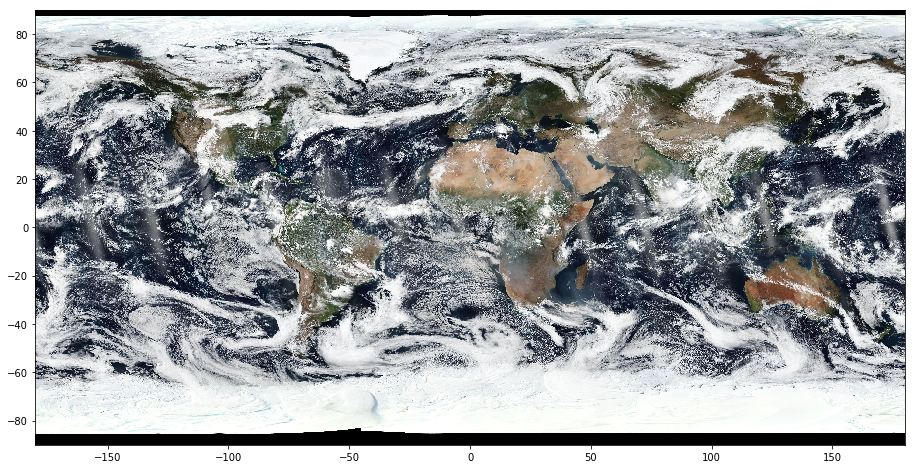

In [4]:
# Plot a sample image
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(images[0], extent=(-180, 180, -90, 90));

## Identify the clouds
We apply a standard deviation cut on the RGB colors of each image. Specifically, we require that the standard deviation divided by the mean in each pixel be less than `0.05`. This effectively masks pixels that are sufficiently bright in one band compared to others and pixels that are overall dark.

100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


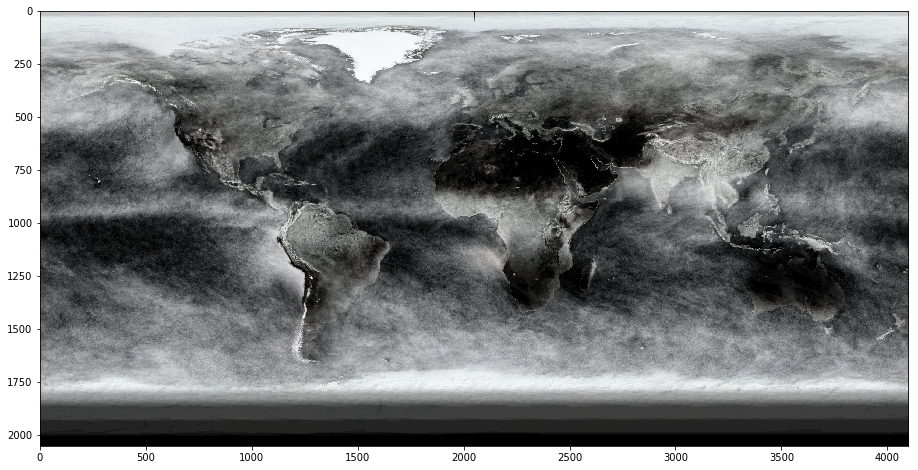

In [5]:
# Clouds as a stddev cut on the RGB colors (they should be *white*)
clouds = np.array(images)
for n in tqdm(range(len(clouds))):
    inds = (np.std(clouds[n], axis=2) / np.mean(clouds[n], axis=2) < 0.05)
    clouds[n][~inds, :] = 0
avgclouds = np.nanmean(clouds, axis=0)
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(avgclouds);

## Process the image
Take the mean across the RGB bands and blur it with a Gaussian filter.

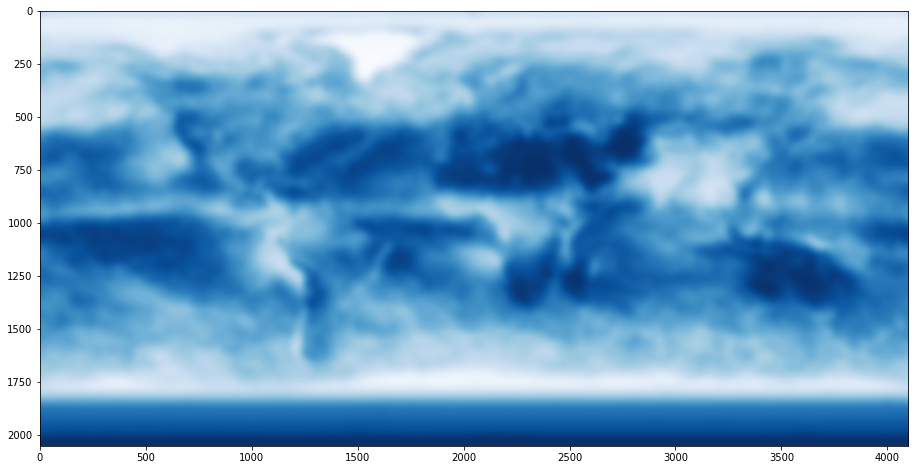

In [6]:
# Monochrome
avggrey = np.nanmean(avgclouds, axis=-1)

# Blur it
avggrey = ndimage.gaussian_filter(avggrey, sigma=20)
avggrey = (avggrey - np.nanmin(avggrey)) / (np.nanmax(avggrey) - np.nanmin(avggrey))

fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(avggrey, cmap="Blues_r");

## Expand the image in spherical harmonics
up to degree 25, then smooth it again.

In [10]:
# Load the image
map = starry.Map(25)
map.load(avggrey, sigma=0.05)

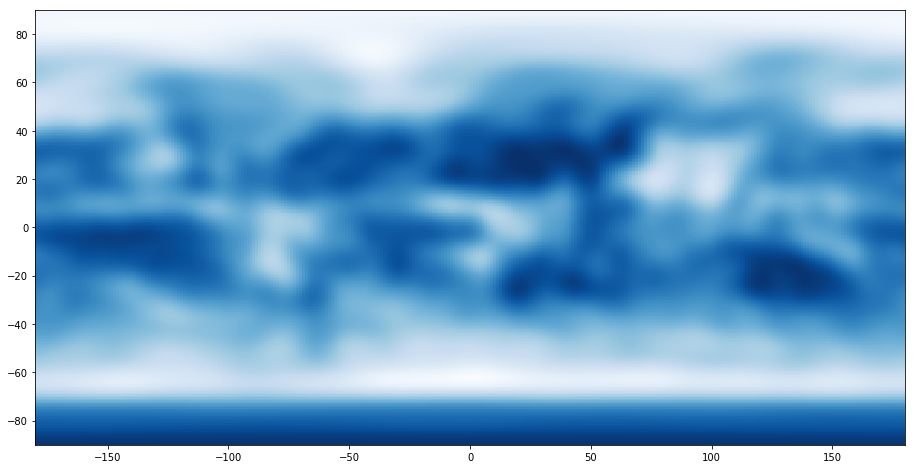

In [11]:
# Render it
Z = map.render(projection="rect")
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(Z, cmap="Blues_r", origin="lower", extent=(-180, 180, -90, 90));

In [12]:
# Save it!
np.savez("../data/viirs.npz", Ztru=Z)